In [1]:
!pip install -q kagglehub torch lightning wandb

In [2]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

## Convert the data into Lightning Modules

In [3]:
from data.dataset import UnpairedImageDataset
from data.datamodule import UnpairedDataModule

datamodule = UnpairedDataModule(
    dataset_id="balraj98/horse2zebra-dataset",
    train_a_subdir="trainA",
    train_b_subdir="trainB",
    test_domain_a_dir="/exchange/cvai/GANerate_your_dreams/test_images",
    test_domain_b_dir="/exchange/cvai/GANerate_your_dreams/test_ghibli_images",  
    batch_size=8,
    num_workers=4
)

datamodule.prepare_data() 
datamodule.setup(stage="fit") 

100%|██████████| 111M/111M [00:03<00:00, 30.8MB/s] 

Extracting files...


Domain A path: /home/jovyan/.cache/kagglehub/datasets/balraj98/horse2zebra-dataset/versions/1/trainA
Domain B path: /home/jovyan/.cache/kagglehub/datasets/balraj98/horse2zebra-dataset/versions/1/trainB
Test domain path: /exchange/cvai/GANerate_your_dreams/test_images
Test domain path: /exchange/cvai/GANerate_your_dreams/test_ghibli_images


In [4]:
batch = next(iter(datamodule.train_dataloader()))
print("Domain A batch shape:", batch["a"].shape)
print("Domain B batch shape:", batch["b"].shape)

Domain A batch shape: torch.Size([8, 3, 256, 256])
Domain B batch shape: torch.Size([8, 3, 256, 256])


In [5]:
datamodule.setup(stage="test")
batch_test = next(iter(datamodule.test_dataloader()))
print("Domain A batch shape:", batch_test["a"].shape)
print("Domain B batch shape:", batch_test["b"].shape)

Domain A batch shape: torch.Size([6, 3, 256, 256])
Domain B batch shape: torch.Size([6, 3, 256, 256])


### Check resized image

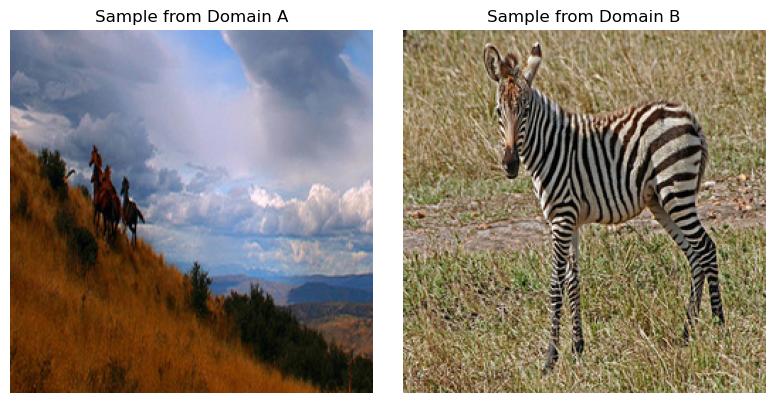

In [6]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF

def denormalize(tensor):
    return tensor * 0.5 + 0.5 

a_tensor = batch["a"][0]
b_tensor = batch["b"][0]

a_img = denormalize(a_tensor).permute(1, 2, 0).numpy()
b_img = denormalize(b_tensor).permute(1, 2, 0).numpy()

fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].imshow(a_img)
axs[0].set_title("Sample from Domain A")
axs[0].axis("off")

axs[1].imshow(b_img)
axs[1].set_title("Sample from Domain B")
axs[1].axis("off")

plt.tight_layout()
plt.show()

# Training

In [7]:
import cycleGAN

## Example Training

In [ ]:
training = cycleGAN.Training("sample-training", cycleGAN.TrainableCycleGAN(cycleGAN.CycleGANConfig(), cycleGAN.TrainConfig()), datamodule)

In [ ]:
training()

## Example Sweep

In [8]:
from cycleGAN.training_defaults import  ENTITY_NAME, PROJECT_NAME

In [9]:
sweep_config = {
    "name": "horse2zebra",
    "method": "random",
    "metric": {"name": "valid_loss", "goal": "minimize"},
    "parameters": {
        "max_epochs": {"value": 200},
        "start_epoch": {"value": 0},
        "decay_epoch": {"value": 100},
        "learning_rate": {"value": 1e-5},
        "lambda_cycle": {"values": [10.0]},
        "lambda_identity": {"values": [0.1]},
        "gradient_acc_steps": {"value": 4},
        "save_location": {"value": "/exchange/cvai/GANerate_your_dreams/"}
    },
}

In [10]:
sweep = cycleGAN.Sweep("horse2zebra", PROJECT_NAME, ENTITY_NAME, cycleGAN.CycleGANConfig(), sweep_config, datamodule, count=1)

In [ ]:
sweep()

wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Create sweep with ID: wzjjwpn6
Sweep URL: https://wandb.ai/cvai-ganerate-your-dreams/ganerate-your-dreams/sweeps/wzjjwpn6


wandb: Agent Starting Run: 3yii3knb with config:
wandb: 	decay_epoch: 100
wandb: 	gradient_acc_steps: 4
wandb: 	lambda_cycle: 10
wandb: 	lambda_identity: 0.1
wandb: 	learning_rate: 1e-05
wandb: 	max_epochs: 200
wandb: 	save_location: /exchange/cvai/GANerate_your_dreams/
wandb: 	start_epoch: 0
wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: schurtenberger-david (cvai-ganerate-your-dreams) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Seed set to 42
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A16') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


Domain A path: /home/jovyan/.cache/kagglehub/datasets/balraj98/horse2zebra-dataset/versions/1/trainA
Domain B path: /home/jovyan/.cache/kagglehub/datasets/balraj98/horse2zebra-dataset/versions/1/trainB
Test domain path: /exchange/cvai/GANerate_your_dreams/test_images
Test domain path: /exchange/cvai/GANerate_your_dreams/test_ghibli_images


/opt/conda/lib/python3.12/site-packages/lightning/pytorch/loggers/wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type     | Params | Mode 
---------------------------------------------------
0 | loss_gan      | MSELoss  | 0      | train
1 | loss_cycle    | L1Loss   | 0      | train
2 | loss_identity | L1Loss   | 0      | train
3 | model         | CycleGAN | 23.6 M | train
---------------------------------------------------
23.6 M    Trainable params
0         Non-trainable params
23.6 M    Total params
94.261    Total estimated model params size (MB)
265       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



## Example Evaluation

In [ ]:
# This might still  be subject to change

artifact_name = "model-ambawxot"
artifact_version = "v3"
artifact_path = f"{ENTITY_NAME}/{PROJECT_NAME}/{artifact_name}:{artifact_version}"

evaluation = cycleGAN.Evaluation("sample-eval", PROJECT_NAME, ENTITY_NAME, artifact_path, datamodule)
evaluation()